In [18]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import correlate
from scipy.optimize import curve_fit

from pathlib import Path
import re

In [31]:
column_mapping = {
    'freq[Hz]': 'freq',
    're:Magnitude_Z<-S11[Ohm]': 'magnitude_re',
    'im:Magnitude_Z<-S11[Ohm]': 'magnitude_im',
    're:Phase_S11': 'phase_re',
    'im:Phase_S11': 'phase_im',    
    're:Smith_S11': 'smith_re',
    'im:Smith_S11': 'smith_im'
}


def make_dataset(f):
    """
    1. add medium label and run number according to the file name
    2. rename columns using the global `column_mapping`, remove other columns
    3. detect and correct phase 2pi jumps
    4. fit and subtract linear phase bias due to cable
    5. scale freq to MHz
    """
    #res = re.match("[^/]*/(voda|vzduch|pisek)([0-9]*)_([0-9]).csv", str(f))
    res = re.match("[^/]*/Trubky_(.*).csv", str(f))
    
    case = res.groups()[0]
    df = pd.read_csv(f, sep=';', comment='#', encoding='latin-1')

    # Rename columns based on the mapping
    unknown_cols = [c for c in df.columns if c not in column_mapping]
    df.drop(columns=unknown_cols, inplace=True)
    df.rename(columns=column_mapping, inplace=True)
    
    #df['phase_fix'] = phase_fix(np.array(df.phase_re)) 
    #speed, shift = np.polyfit(df.freq, df.phase_fix, deg=1)
    #print(f"{medium}, #{i_run}: cable_phase = {shift} + {speed} * freq")
    #df['phase_cal_shift'] = shift
    #df['phase_cal_speed'] = speed
    df['medium'] = len(df)*[case]
    #df['saturation'] = saturation
    df['run'] = len(df)*[1]

    df.freq /=1e6
    return df
           
measurement_dir=Path("./2024_04_18_dosah")
datasets = [
    make_dataset(f)
    for f in measurement_dir.glob("*.csv")
]
df = pd.concat(datasets, ignore_index=True)

print(df[0:10])

   freq  smith_re  smith_im  magnitude_re  magnitude_im  phase_re  phase_im  \
0  80.0 -0.808171 -0.425801      2.398768    -12.339235 -0.808171 -0.425801   
1  80.5 -0.829171 -0.379980      2.408001    -10.886902 -0.829171 -0.379980   
2  81.0 -0.848087 -0.332280      2.415584     -9.424142 -0.848087 -0.332280   
3  81.5 -0.864501 -0.283256      2.423707     -7.964245 -0.864501 -0.283256   
4  82.0 -0.878126 -0.233381      2.434919     -6.515697 -0.878126 -0.233381   
5  82.5 -0.889171 -0.183228      2.439973     -5.086091 -0.889171 -0.183228   
6  83.0 -0.897162 -0.132386      2.454886     -3.660364 -0.897162 -0.132386   
7  83.5 -0.901986 -0.082464      2.477983     -2.275274 -0.901986 -0.082464   
8  84.0 -0.903319 -0.029463      2.527205     -0.813124 -0.903319 -0.029463   
9  84.5 -0.901409  0.023870      2.584302      0.660124 -0.901409  0.023870   

   medium  run  
0  voda_3    1  
1  voda_3    1  
2  voda_3    1  
3  voda_3    1  
4  voda_3    1  
5  voda_3    1  
6  voda_3  

In [33]:
def narrow_phase_jumps(phase):
    phase_diff = np.pad(phase[1:] - phase[:-1], pad_width=(1,0))
    phase_jump = np.cumsum(phase_diff > 300)  
    phase_fix = phase - 360 * phase_jump
    #plt.plot(phase_fix)
    return phase_fix



# Define the model function
def model(freq, a, b, c, d, e):
    return a + b * freq + c * np.sin(d * freq + e)


def phase_line_fit(freq, phase):
    freq = np.array(freq)
    phase = np.array(phase)
    phase_full = narrow_phase_jumps(phase)
    # Estimate linear term
    speed, shift = np.polyfit(freq, phase_full, deg=1)# Step 1: Reshape 'phase' into (n_media, n_vals)
# Group by 'medium' and collect phase values
grouped = df.groupby('medium')['phase'].apply(list)

# Create a 2D array: each row corresponds to a medium, each column to a value
phase_matrix = np.array(grouped.tolist())

# Step 2: Subtract a broadcasted array (n_vals,)
# Compute a broadcasted array (e.g., mean of each row for calibration)
broadcast_array = np.mean(phase_matrix, axis=1, keepdims=True)
calibrated_matrix = phase_matrix - broadcast_array

# Step 3: Flatten the calibrated values and assign to a new column
# Map calibrated values back to the original DataFrame
df['phase_calibrated'] = np.concatenate(calibrated_matrix)
    phase_calibrated = phase_full - shift - speed * freq
    # Estimate amplitude
    amplitude = np.abs(phase_calibrated.max() - phase_calibrated.min()) 
    # Estimate base freq using FFT
    corr = correlate(phase_calibrated, phase_calibrated, mode='full')
    corr = corr[corr.size // 2:]  # Keep only positive lags
    lags = np.arange(len(corr))
    peak_lag = lags[np.argmax(corr[1:]) + 1]  # Ignore zero lag
    freq_period = peak_lag * (freq[-1] - freq[0]) / len(phase_calibrated)
    
    # Fit the model to the data
    initial_guess = [shift, speed, amplitude, freq_period/2/np.pi, 0]  # Initial guess for parameters
    print("init guess: ", initial_guess)
    params, covariance = curve_fit(model, freq, phase, p0=initial_guess)
    print("fit params: ", params)
    
    # Extract fitted parameters and their uncertainties
    shift, speed, amplitude, freq_scale, freq_phase = params
    param_uncertainties = np.sqrt(np.diag(covariance))
    print("uncert params: ", param_uncertainties)
    return model(freq, *params)

print(df['medium'].unique())
air_mask = (df['medium'] == "vzduch")
print(np.sum(air_mask))
phase_line = phase_line_fit(df.loc[air_mask, 'freq'], df.loc[air_mask, 'phase_re'])
#plt.plot(phase_calibrated)

grouped = df.groupby('medium')['phase_re'].apply(list)
phase_matrix = np.array(grouped.tolist())
phase_calibrated = phase_matrix - phase_line
df['phase_calibrated'] = phase_calibrated.flatten()

['voda_3' 'vzduch' 'voda_2' 'voda_1']
201
init guess:  [np.float64(-1.0562727427457277), np.float64(0.008162999155217936), np.float64(2.017195292491701), np.float64(0.07918156372731111), 0]
fit params:  [-2.13235837e-02  4.83310847e-05  8.85534389e-01  1.10665953e-01
 -4.77107456e+00]
uncert params:  [7.74592567e-03 5.80921058e-05 2.17956758e-03 9.93552337e-05
 1.32911407e-02]


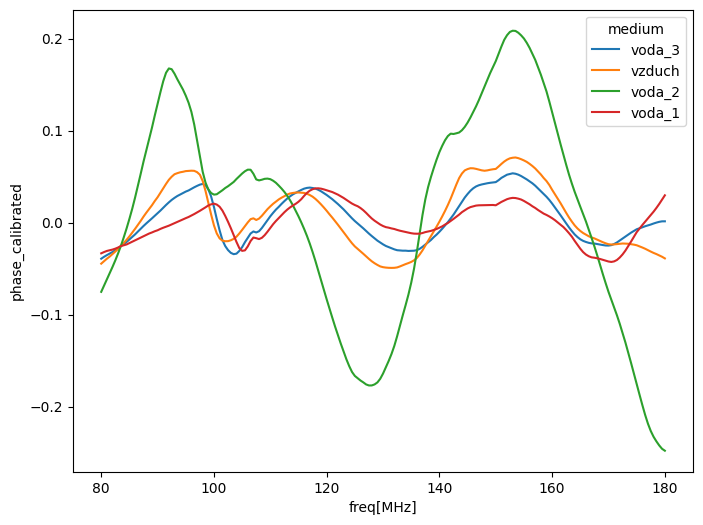

In [35]:
"""
Plot phase runs.
"""
def plot_quantity(df, col_name):
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df, x='freq', y=col_name, hue='medium')

    # Add labels and title
    plt.xlabel('freq[MHz]')
    plt.ylabel(f'{col_name}')
    plt.savefig(f'{col_name}.pdf')
    plt.show()


plot_quantity(df, 'phase_calibrated')

Observations:
- tested sensor setup is most sensitive to water in distance about 3cm (case voda_2)
- sensitivity up to water at distance 3.7cm, but already quite close to the air, easily would be shadowed by closer water
- dependency of phase shift on the distance is nontrivial
- these are shifts for water, actual shifts for rock would be much smaller with possibly better dependency of phase on distance
- has to do similar experiment for the full scale sensor, but rather use fixed water bodies
- can test sensitivity to azimuth as well

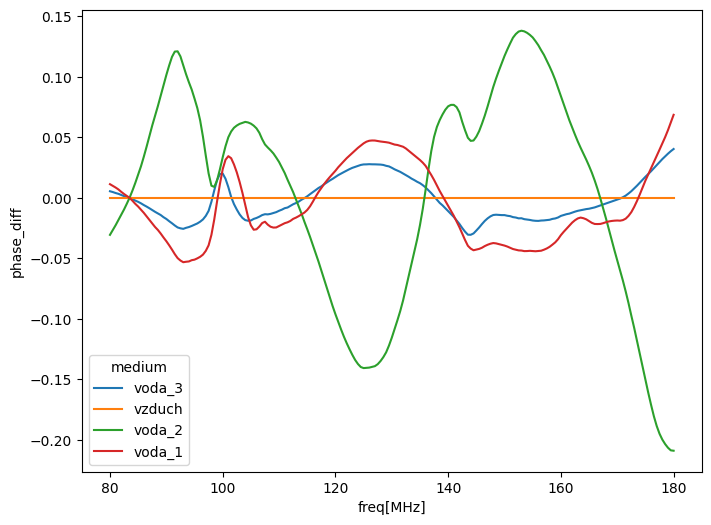

In [36]:
vzduch_phases = df[df['medium'] == 'vzduch'][['freq', 'phase_calibrated']].rename(columns={'phase_calibrated': 'vzduch_phase'})

# Step 2: Merge with the original dataframe on 'freq'
merged_df = df.merge(vzduch_phases, on='freq')

# Step 3: Subtract the 'vzduch' phase from other mediums' phases
merged_df['phase_diff'] = merged_df['phase_calibrated'] - merged_df['vzduch_phase']
plot_quantity(merged_df, 'phase_diff')

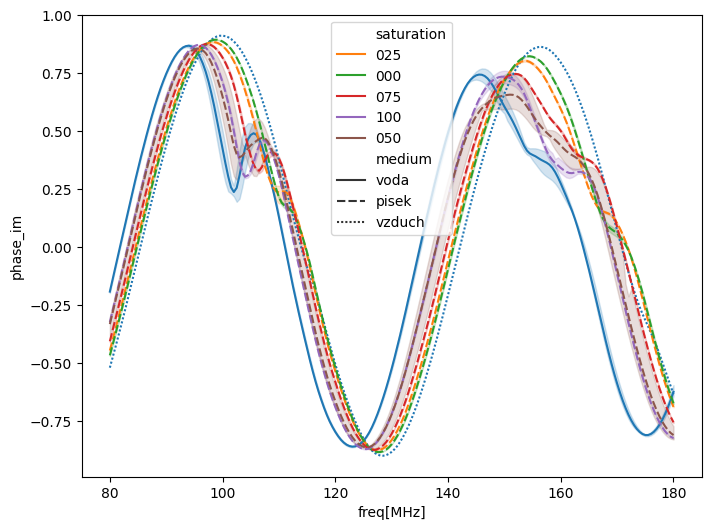

In [19]:
plot_quantity(df, 'phase_im')

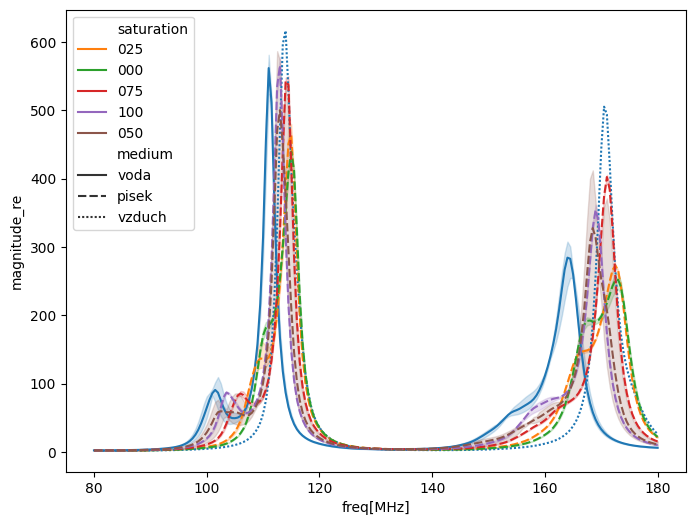

In [14]:
"""
Plot impedance / magnitude.
"""
plot_quantity(df, 'magnitude_re')

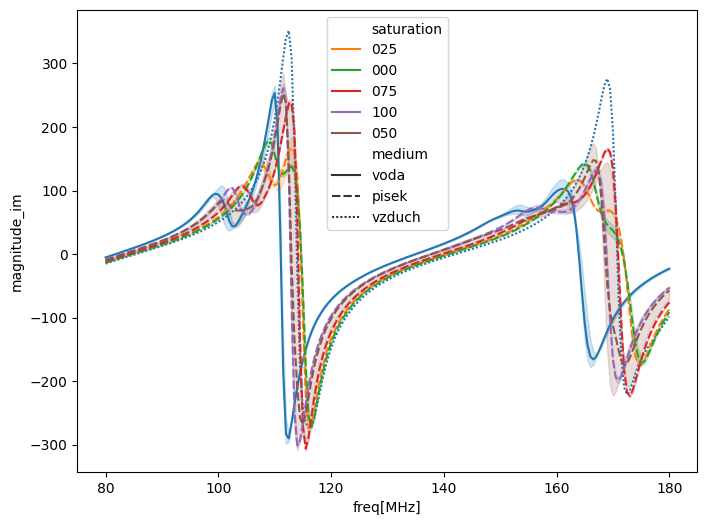

In [20]:
plot_quantity(df, 'magnitude_im')

The difference is clearly above the noise which possibly is due to change in the spatial setup of the measurement. We notice a big sensitivity of the measurement to:

1. particular position and bending of the coaxial cable
2. our presence in about 1m perimeter

The sensitivity seems to be good in the three intervals: $80$ - $90$, $90$ - $120$m, and $150$-$170$ MHz. To better visualize the sensitivity, we shall display ratio:

$$
\frac{|\phi_w(f) - \phi_a(f)|}{\sqrt{\frac12 (\sigma_w^2 + \sigma_a^2)}}
$$
where $\phi_w$, $\phi_a$ are the phase measurements for the water and the air respectively, and $\sigma$ denotes standard deviation from three runs.

In [8]:
"""
Resample runs to the common grid.
Group by the frequency and medium.
"""
from scipy.interpolate import interp1d

n_samples = 50
freq_common = np.linspace(85, 150, n_samples)

def resample_quantity(group, q_name):
    interp_func = interp1d(group['freq'], group[q_name], kind='linear')
    return interp_func(freq_common)

def resample_group(group):
    phase = resample_quantity(group, 'phase_calibrated')
    mag = resample_quantity(group, 'magnitude')
    resampled_df = pd.DataFrame({'freq': freq_common,
                                 'phase': phase,
                                 'mag': mag,
                                 'medium': group['medium'].unique()[0],
                                 'run': group['run'].unique()[0]})
    return resampled_df


groups = df.groupby(['medium', 'run'])    
groups_df = [resample_group(group) for _, group in groups]
resampled_df = pd.concat(groups_df, ignore_index=True)    
print(resampled_df)

           freq      phase       mag  medium run
0     85.000000 -21.613453 -1.701099    voda   0
1     86.326531 -23.233291 -2.103808    voda   0
2     87.653061 -24.349241 -2.799965    voda   0
3     88.979592 -23.689295 -3.823483    voda   0
4     90.306122 -18.183710 -5.136304    voda   0
..          ...        ...       ...     ...  ..
295  144.693878  -2.869002 -0.918269  vzduch   2
296  146.020408  -2.718669 -0.947095  vzduch   2
297  147.346939  -2.415046 -0.981345  vzduch   2
298  148.673469  -1.963005 -1.015423  vzduch   2
299  150.000000  -1.510853 -1.043386  vzduch   2

[300 rows x 5 columns]


c std
 [1.17306099 1.51219943 2.10798578 3.40223822 6.8999215  8.06028771
 7.73598199 3.73725322 0.93949881 1.09628046 0.96804457 0.58651403
 0.72658576 1.33601777 1.68254879 1.73054993 1.59784571 1.48601974
 1.47511804 1.35889099 1.26074936 1.24526621 1.35696706 1.69607206
 2.21961595 1.79554782 1.10882781 1.41360545 1.22996349 1.06341047
 1.01584953 1.02505898 1.06641737 1.13695252 1.22175373 1.29668517
 1.33205709 1.38515471 1.446984   1.51038956 1.55931556 1.60132923
 1.63151891 1.6689205  1.75023786 1.8614985  1.98073513 2.09371653
 2.13737374 2.12921147]
c std
 [0.10170438 0.2033289  0.46562163 0.85746581 0.77755425 0.60940394
 0.54609952 0.91894464 0.70070819 0.45091366 0.3196914  0.28646504
 0.31374173 0.28198862 0.20190618 0.1302288  0.07915429 0.06371184
 0.05764047 0.06837999 0.08870637 0.11542767 0.12742796 0.1169101
 0.11239276 0.32526903 0.30581456 0.13080854 0.05025746 0.03704102
 0.03426791 0.03186314 0.02775876 0.02656787 0.02650897 0.02676577
 0.02764819 0.0281814  0.

Text(0, 0.5, 'sensitivity: ($\\overline{q}_w - \\overline{q}_a) / \\sigma$')

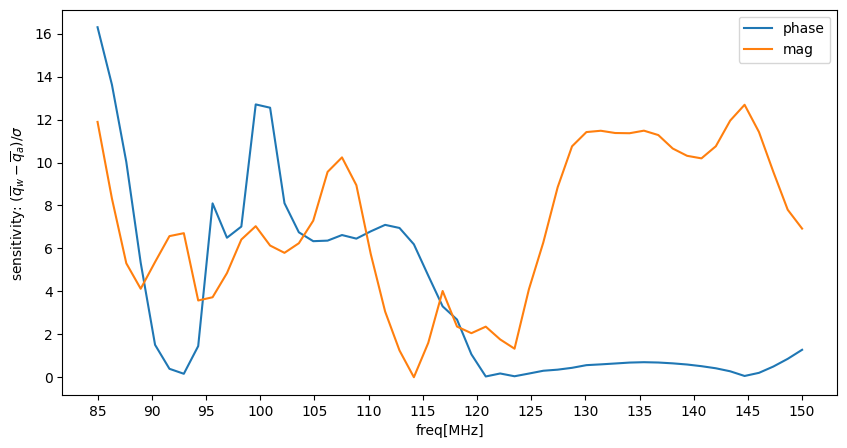

In [9]:
"""
Now calculate statistics over runs.
"""
ops = ['mean', 'std']
run_stats = resampled_df.groupby(['freq', 'medium']).agg({'phase': ops, 'mag': ops})
#print(run_stats)
#water_stat, air_stat = [g for m, g in run_stats.groupby(['medium'])]


def sensitivity(df, q_name):
    water_stat, air_stat = [g for m, g in df.groupby(['medium'])]
    #print(air_stat)
    q_water = water_stat[q_name]
    q_air = air_stat[q_name]
    mean_w, mean_a = [np.array(q['mean']) for q in [q_water, q_air]]
    diff = mean_w - mean_a

    std_w, std_a = [np.array(q['std']) for q in [q_water, q_air]]
    common_std = np.sqrt(0.5 * (std_w**2 + std_a**2))
    
    print("c std\n", common_std)
    
    return np.abs(diff) / common_std

phase_sens = sensitivity(run_stats, 'phase')
mag_sens = sensitivity(run_stats, 'mag')

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(freq_common, phase_sens, label='phase')
ax.plot(freq_common, mag_sens, label='mag')
ax.legend()
ax.set_xticks(np.arange(min(freq_common), max(freq_common)+1, 5.0))
ax.set_xlabel('freq[MHz]')
ax.set_ylabel('sensitivity: ($\overline{q}_w - \overline{q}_a) / \sigma$')

For the phase, we can use frequencies from the interval $95$-$115$ in particular the freqency $100$ has high sensitivity. For the magnitude the interval $98$-$110$ has similar sensitivity to the phase and there seems to be high sensitivity in the interval $130$-$150$.